<a href="https://colab.research.google.com/github/pharringtonp19/econometrics/blob/main/notebooks/approximation/kernels/Kernels_Modeling_Frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%%capture 
!pip install tinygp 
!pip install flax 
!pip install optax 

Copied from [TinyGP](https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html)

In [27]:
import jax 
import jax.numpy as jnp 
import matplotlib.pyplot as plt 
from tinygp import kernels, GaussianProcess 
import flax.linen as nn 
from flax.linen.initializers import zeros 
import optax 

In [41]:
init_key = jax.random.PRNGKey(0)
subkey1, subkey2 = jax.random.split(init_key, 2)

def f(x):
  """Function of Interest: maps x -> y"""
  return 0.2 * (x - 5) + jnp.sin(3 * x + 0.1 * (x - 5) ** 2)

def dist1(key): 
  return jax.random.uniform(key, minval=0.0, maxval=3.8)

def dist2(key): 
  return jax.random.uniform(key, minval=5.5, maxval=10.)

def dist3(key): 
  return jax.random.uniform(key, minval=.08, maxval=.22)

def dist4(key): 
  return jax.random.normal(key)

def sample(key): 
  subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 4)
  condition = jax.random.bernoulli(key, p = 18/(28+18))
  x =  jax.lax.cond(condition, dist1, dist2, subkey2)
  err = dist3(subkey3)
  y = f(x) + err *dist4(subkey4)
  return y, x, err

(DeviceArray(-0.56983346, dtype=float32),
 DeviceArray(5.888079, dtype=float32),
 DeviceArray(0.21844266, dtype=float32))

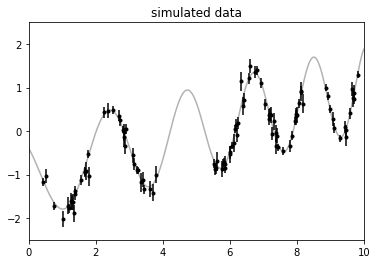

In [51]:
keys = jax.random.split(subkey1, 100) 
(ys, xs, errs) = jax.vmap(sample)(keys)

true_xs = jnp.linspace(0., 10., 1000)
true_ys = f(true_xs) 

plt.plot(true_xs, true_ys, "k", lw=1.5, alpha=0.3)
plt.errorbar(xs, ys, yerr=errs, fmt=".k", capsize=0)
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [ ]:
class GPModule(nn.Module): 
  @nn.compact 
  def __call__(self, x, yerr, y, t): 
    mean = self.param("mean", zeros, ())
    log_jitter = self.param("log_jitter", zeros, ())
    log_sigma1 = self.param("log_sigma1", zeros, ())
    log_rho1 = self.param("log_rho1", zeros, ())
    log_tau = self.param("log_tau", zeros, ())
    kernel1 = (
        jnp.exp(2 * log_sigma1) * kernels.ExpSquared(jnp.exp(log_tau))
        * kernels.Cosine(jnp.exp(log_rho1))
    )